# Анализ кредитного рейтинга человека
Необходимо, используя различные данные о человеке оценить риски по выдаче заёма.  
Учитывая информацию о кредитоспособности человека, создайть модель машинного обучения, которая может классифицировать кредитный рейтинг.

In [80]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from itertools import permutations

### Считываем данные

In [4]:
data = pd.read_csv("D:/datasets/train.csv")
data.head(5)

C:\Users\soldd\AppData\Local\Temp\ipykernel_15016\3420928094.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("D:/datasets/train.csv")


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [5]:
data.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [6]:
credit_data = data.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Month'], axis=1)
credit_data.shape

(100000, 23)

In [7]:
credit_data.columns

Index(['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

Столбцы (признаки):

- `Month` - месяц подачи заявки
- `Age` - возраст заёмщика
- `Occupation` - род деятельности
- `Annual_Income` - годовой доход 
- `Monthly_Inhand_Salary` - месячная зароботная плата 
- `Num_Bank_Accounts` - количество банковских счетов
- `Num_Credit_Card` - количетство кредитных карт
- `Interest_Rate` - процентная ставка по кредитной карте 
- `Num_of_Loan` - количество заёмов до
- `Delay_from_due_date` - среднее количество дней задержки по платежу(отрицательные значения - ранняя оплата)
- `Num_of_Delayed_Payment` - среднее количество задержанных платежей
- `Changed_Credit_Limit` - процентное изменение лимита по кредитной карте 
- `Num_Credit_Inquiries` - количество заявок для кредитной карты
- `Credit_Mix` - класс набора предыдущих кредитов
- `Outstanding_Debt` - оставшиеся задолжности
- `Credit_Utilization_Ratio` - коэффициент использования кредитной карты
- `Credit_History_Age` - возраст кредитной истории
- `Payment_of_Min_Amount` - была ли выплачена только минимальная сумма
- `Total_EMI_per_month` - ежемесячный платёж
- `Amount_invested_monthly` - ежемесячная сумма инвестирования заёмщика
- `Payment_Behaviour` - платёжное поведение
- `Monthly_Balance` - ежемесячный баланс заёмщика
- `Credit_Score` - класс кредитного рейтинга

Некоторые столбцы были удалены в силу их заведомой бесполезности.

Присутсвтуют как категориальные, так и числовые признаки

Требуется предсказать класс `Credit_Score` по остальным признакам.

Имеется три класса `Credit_Score`: good, standard, poor

In [8]:

credit_data.Occupation = credit_data.Occupation.astype('category')
credit_data.Credit_Mix = credit_data.Credit_Mix.astype('category')
credit_data.Payment_of_Min_Amount = credit_data.Payment_of_Min_Amount.astype('category')
credit_data.Payment_Behaviour = credit_data.Payment_Behaviour.astype('category')
credit_data.Credit_Score = credit_data.Credit_Score.astype('category')
credit_data.Type_of_Loan = credit_data.Type_of_Loan.astype('category')

In [9]:
numerical_featues = (credit_data.select_dtypes([int,float]).columns).tolist()
numerical_featues

['Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Delay_from_due_date',
 'Num_Credit_Inquiries',
 'Credit_Utilization_Ratio',
 'Total_EMI_per_month']

In [10]:
columns_list = [column for column in credit_data]
non_numerical_featues = list(set(columns_list) - set(numerical_featues))
non_numerical_featues

['Credit_Mix',
 'Age',
 'Occupation',
 'Payment_Behaviour',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Monthly_Balance',
 'Payment_of_Min_Amount',
 'Amount_invested_monthly',
 'Annual_Income',
 'Outstanding_Debt',
 'Credit_History_Age',
 'Credit_Score',
 'Type_of_Loan',
 'Num_of_Loan']

#### Удаление лишних символов из числовых значений и приведение их к числовому типу, правильное переобозначение пропущенных значений

In [11]:
credit_data['Age'] = credit_data['Age'].str.rstrip("_")
credit_data['Age'] = pd.to_numeric(credit_data['Age'], errors='coerce')

credit_data['Annual_Income'] = credit_data['Annual_Income'].str.rstrip("_")
credit_data['Annual_Income'] = pd.to_numeric(credit_data['Annual_Income'], errors='coerce')

credit_data['Num_of_Delayed_Payment'] = credit_data['Num_of_Delayed_Payment'].str.rstrip("_")
credit_data['Num_of_Delayed_Payment'] = pd.to_numeric(credit_data['Num_of_Delayed_Payment'], errors='coerce')

credit_data['Outstanding_Debt'] = credit_data['Outstanding_Debt'].str.rstrip("_")
credit_data['Outstanding_Debt'] = pd.to_numeric(credit_data['Outstanding_Debt'], errors='coerce')

credit_data['Amount_invested_monthly'] = credit_data['Amount_invested_monthly'].str.rstrip("_")
credit_data['Amount_invested_monthly'] = credit_data['Amount_invested_monthly'].replace('__10000__',np.nan)
credit_data['Amount_invested_monthly'] = pd.to_numeric(credit_data['Amount_invested_monthly'], errors='coerce')

credit_data['Num_of_Loan'] = credit_data['Num_of_Loan'].str.rstrip("_")
credit_data['Num_of_Loan'] = pd.to_numeric(credit_data['Num_of_Loan'], errors='coerce')

credit_data['Monthly_Balance'] = credit_data['Monthly_Balance'].str.rstrip("_")
credit_data['Monthly_Balance'] = pd.to_numeric(credit_data['Monthly_Balance'], errors='coerce')

credit_data['Changed_Credit_Limit'] = credit_data['Changed_Credit_Limit'].replace("_",np.nan)
credit_data['Changed_Credit_Limit'] = pd.to_numeric(credit_data['Changed_Credit_Limit'], errors='coerce')

credit_data['Credit_Mix'] = credit_data['Credit_Mix'].replace("_",np.nan) 

credit_data['Occupation'] = credit_data['Occupation'].replace("_______",np.nan) 

credit_data['Payment_Behaviour'] = credit_data['Payment_Behaviour'].replace('!@9#%8',np.nan)

C:\Users\soldd\AppData\Local\Temp\ipykernel_15016\1191727484.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  credit_data['Credit_Mix'] = credit_data['Credit_Mix'].replace("_",np.nan)
C:\Users\soldd\AppData\Local\Temp\ipykernel_15016\1191727484.py:28: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  credit_data['Occupation'] = credit_data['Occupation'].replace("_______",np.nan)
C:\Users\soldd\AppData\Local\Temp\ipykernel_15016\1191727484.py:30: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future v

In [12]:
def convert_to_months(column):
    if pd.isna(column):
        return np.nan
    parts = column.split(" and ")
    years = 0
    months = 0
    for part in parts:
        if 'Year' in part:
            years = int(part.split()[0])
        elif 'Month' in part:
            months = int(part.split()[0])
    total_months = years * 12 + months
    return total_months


credit_data['Credit_History_Age'] = credit_data['Credit_History_Age'].apply(convert_to_months)
credit_data = credit_data.rename({'Credit_History_Age' : 'Credit_History_Month'})

In [13]:
numerical_featues = (credit_data.select_dtypes([int,float]).columns).tolist()
numerical_featues

['Age',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Credit_History_Age',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Monthly_Balance']

In [14]:
columns_list = [column for column in credit_data]
non_numerical_featues = list(set(columns_list) - set(numerical_featues))
non_numerical_featues

['Credit_Mix',
 'Payment_Behaviour',
 'Occupation',
 'Payment_of_Min_Amount',
 'Credit_Score',
 'Type_of_Loan']

### Обработаем выбросы в некоторых признаках 
Возраст заёмщика должен находится в промежутке от 20 до 100 лет, поэтому все строки с другими значениями отбросим

In [15]:
credit_data = credit_data[(credit_data.Age > 0) & (credit_data.Age <= 100)]
credit_data.shape

(97224, 23)

Количество банковских счетов - величина неотрицательная  
Аналогично с другими признаками отражающими количество чего-либо(Кроме `Delay_from_due_date`)

In [16]:
credit_data = credit_data[credit_data.Num_Bank_Accounts >= 0]
credit_data = credit_data[credit_data.Num_Credit_Card >= 0]
credit_data = credit_data[credit_data.Num_of_Loan >= 0]
credit_data = credit_data[credit_data.Num_of_Delayed_Payment >= 0]
credit_data = credit_data[credit_data.Credit_History_Age >= 0]
credit_data.shape

(78500, 23)

### Заполнение пропущенных значений

In [17]:
credit_data.isnull().sum()

Age                             0
Occupation                   5537
Annual_Income                   0
Monthly_Inhand_Salary       11821
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                 8888
Delay_from_due_date             0
Num_of_Delayed_Payment          0
Changed_Credit_Limit         1649
Num_Credit_Inquiries         1537
Credit_Mix                  15889
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age              0
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      6888
Payment_Behaviour            5905
Monthly_Balance              2217
Credit_Score                    0
dtype: int64

#### Заполним пропущенные значения числовых признаков
Заполним пропущенные значения месячной зароботной платы, используя линейную регрессию по признаку `Annual_Income`

In [18]:
train = credit_data.dropna(subset=['Annual_Income','Monthly_Inhand_Salary'])
test = credit_data[(credit_data['Monthly_Inhand_Salary'].isna()) & (credit_data['Annual_Income'].notna())]

X_train = train[['Annual_Income']]
y_train = train['Monthly_Inhand_Salary']
X_test = test[['Annual_Income']]

regressor = LinearRegression()
regressor.fit(X_train,y_train)

prediction = regressor.predict(X_test)

credit_data.loc[X_test.index,'Monthly_Inhand_Salary'] = prediction

Аналогично поступим с `Monthly_Balance` и `Amount_invested_monthly`

In [19]:
train = credit_data.dropna(subset=['Annual_Income','Monthly_Inhand_Salary', 'Monthly_Balance'])
test = credit_data[(credit_data['Monthly_Balance'].isna()) & (credit_data['Annual_Income'].notna()) & (credit_data['Monthly_Inhand_Salary'].notna())]

X_train = train[['Annual_Income', 'Monthly_Inhand_Salary']]
y_train = train['Monthly_Balance']
X_test = test[['Annual_Income', 'Monthly_Inhand_Salary']]

regressor = LinearRegression()
regressor.fit(X_train,y_train)

prediction = regressor.predict(X_test)

credit_data.loc[X_test.index,'Monthly_Balance'] = prediction

In [20]:
train = credit_data.dropna(subset=['Annual_Income','Monthly_Inhand_Salary', 'Amount_invested_monthly', 'Monthly_Balance'])
test = credit_data[(credit_data['Amount_invested_monthly'].isna()) & (credit_data['Annual_Income'].notna()) & (credit_data['Monthly_Inhand_Salary'].notna()) & (credit_data['Monthly_Balance'].notna())]

X_train = train[['Annual_Income', 'Monthly_Inhand_Salary', 'Monthly_Balance']]
y_train = train['Amount_invested_monthly']
X_test = test[['Annual_Income', 'Monthly_Inhand_Salary', 'Monthly_Balance']]

regressor = LinearRegression()
regressor.fit(X_train,y_train)

prediction = regressor.predict(X_test)

credit_data.loc[X_test.index,'Amount_invested_monthly'] = prediction

In [21]:
credit_data.loc[(credit_data['Amount_invested_monthly'] < 0), 'Amount_invested_monthly'] = 0

In [22]:
credit_data.Changed_Credit_Limit = credit_data.Credit_History_Age.fillna(0)

In [23]:
credit_data.Num_Credit_Inquiries = credit_data.Num_Credit_Inquiries.fillna(0)

In [24]:
credit_data.isnull().sum()

Age                             0
Occupation                   5537
Annual_Income                   0
Monthly_Inhand_Salary           0
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                 8888
Delay_from_due_date             0
Num_of_Delayed_Payment          0
Changed_Credit_Limit            0
Num_Credit_Inquiries            0
Credit_Mix                  15889
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age              0
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly         0
Payment_Behaviour            5905
Monthly_Balance                 0
Credit_Score                    0
dtype: int64

#### Далее заполним пропущенные категориальные признаки

In [25]:
credit_data.Type_of_Loan = credit_data.Type_of_Loan.fillna('Not Specified')

In [26]:
mix_mode = credit_data.Credit_Mix.mode().iloc[0]
credit_data.Credit_Mix = credit_data.Credit_Mix.fillna(mix_mode)
mix_mode

'Standard'

In [27]:
behaviour_mode = credit_data.Payment_Behaviour.mode().iloc[0]
credit_data.Payment_Behaviour = credit_data.Payment_Behaviour.fillna(behaviour_mode)
behaviour_mode

'Low_spent_Small_value_payments'

In [28]:
occupation_mode = credit_data.Occupation.mode().iloc[0]
credit_data.Occupation = credit_data.Occupation.fillna(occupation_mode)
occupation_mode

'Lawyer'

In [29]:
credit_data.isnull().sum()

Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64

### Некоторая описательная статистика

In [30]:
credit_data.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,78500.000000,7.850000e+04,78500.000000,78500.000000,78500.000000,78500.000000,78500.000000,78500.000000,78500.000000,78500.000000,78500.000000,78500.000000,78500.000000,78500.000000,78500.000000,78500.000000,78500.000000
mean,33.264025,1.756041e+05,4191.821391,17.072140,22.716548,73.480624,7.134497,21.170102,31.213121,220.666102,26.673873,1432.953427,32.301920,220.666102,1419.452039,195.893214,403.311950
std,10.782149,1.430253e+06,2930.859755,117.201518,129.840736,471.676062,60.200031,14.877793,226.584119,99.677703,187.435586,1158.933212,5.112852,99.677703,8344.589513,195.517983,212.013033
min,14.000000,7.005930e+03,303.645417,0.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,1.000000,0.000000,0.230000,20.172942,1.000000,0.000000,0.000000,0.007760
25%,24.000000,1.945342e+04,1792.990833,4.000000,4.000000,8.000000,2.000000,10.000000,9.000000,144.000000,3.000000,568.670000,28.080689,144.000000,30.576085,73.257492,270.944294
50%,33.000000,3.757392e+04,3861.745000,6.000000,6.000000,14.000000,3.000000,18.000000,14.000000,219.000000,5.000000,1169.690000,32.330960,219.000000,69.465448,131.509861,338.672152
75%,42.000000,7.278306e+04,5382.855000,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,301.000000,9.000000,1961.870000,36.510898,301.000000,162.238963,242.340103,472.868594
max,100.000000,2.419806e+07,15204.633333,1798.000000,1499.000000,5797.000000,1485.000000,67.000000,4397.000000,404.000000,2594.000000,4998.070000,50.000000,404.000000,82331.000000,1977.326102,1602.040519


In [31]:
credit_data.describe(include=['category'])

,Occupation,Type_of_Loan,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
count,78500,78500,78500,78500,78500,78500
unique,15,6260,3,3,6,3
top,Lawyer,Not Specified,Standard,Yes,Low_spent_Small_value_payments,Standard
freq,10689,9997,44780,41458,25973,41846


In [32]:
credit_data.nunique()

Age                            45
Occupation                     15
Annual_Income               13259
Monthly_Inhand_Salary       21150
Num_Bank_Accounts             787
Num_Credit_Card              1068
Interest_Rate                1442
Num_of_Loan                   347
Type_of_Loan                 6260
Delay_from_due_date            73
Num_of_Delayed_Payment        611
Changed_Credit_Limit          404
Num_Credit_Inquiries         1009
Credit_Mix                      3
Outstanding_Debt            12203
Credit_Utilization_Ratio    78500
Credit_History_Age            404
Payment_of_Min_Amount           3
Total_EMI_per_month         14283
Amount_invested_monthly     78247
Payment_Behaviour               6
Monthly_Balance             77448
Credit_Score                    3
dtype: int64

### Визуализация данных

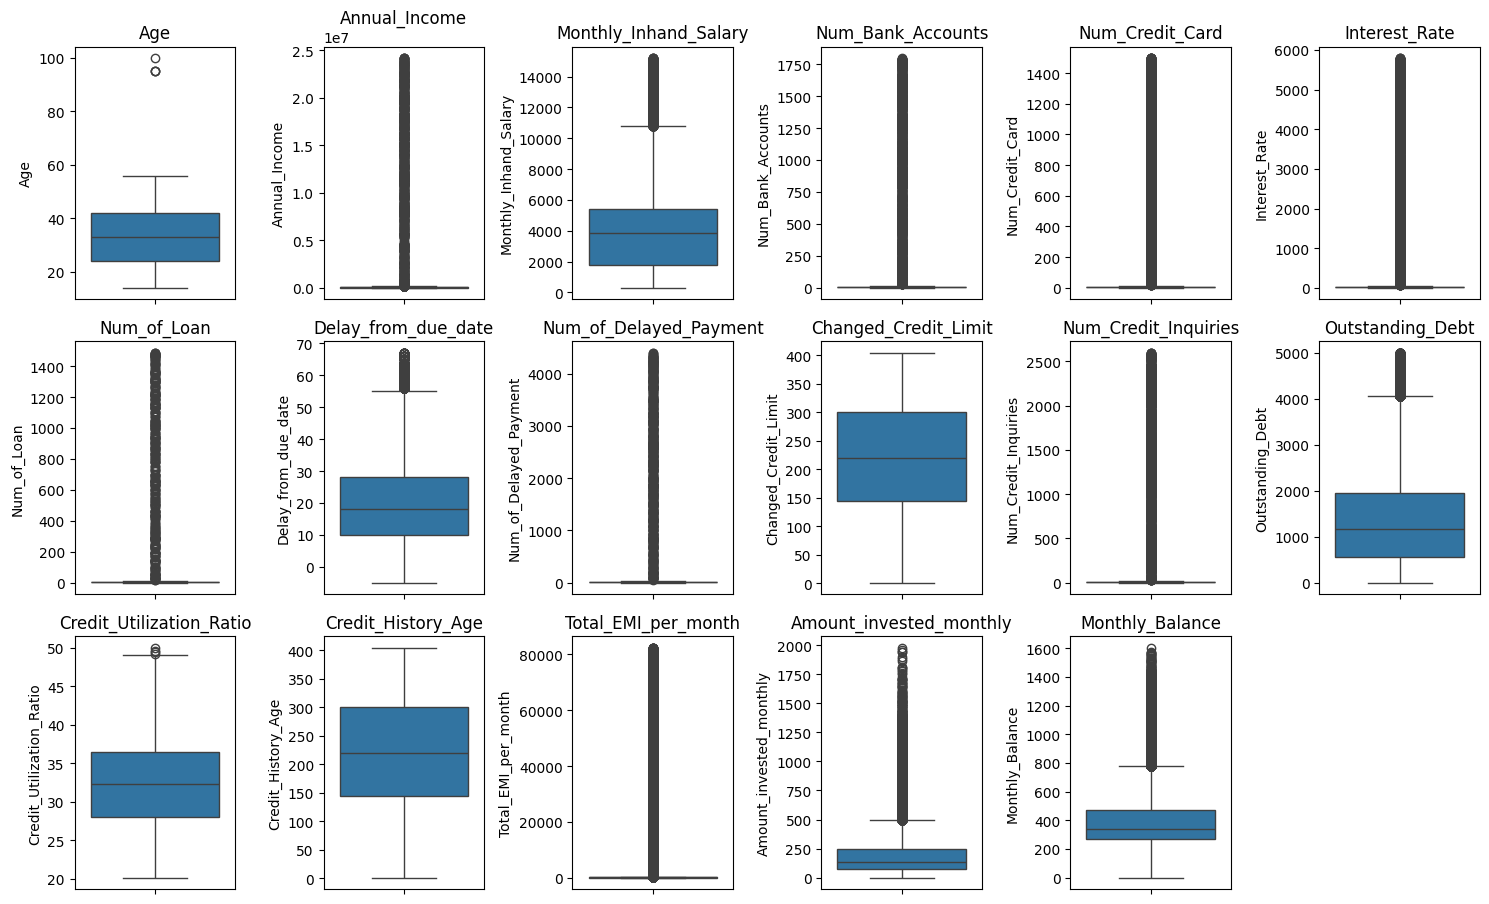

In [33]:
plt.figure(figsize=(15, 15))

for i, column in enumerate(numerical_featues):
    plt.subplot(5, 6, i + 1)  
    sns.boxplot(y=credit_data[column])  
    plt.title(column)

plt.tight_layout()  
plt.show()

Можем заметить экстремальные значения по нескльким признакам, поэтому избавимся от них удалив соответсвующие им строки 

In [34]:
def remove_outliers(data, columns):
    for i in columns:
        q1 = data[i].quantile(0.25)
        q2 = data[i].quantile(0.75)
        tmp = q2 - q1
        lbound = q1 - 1.5 * tmp
        ubound = q2 + 1.5 * tmp
        data = data[(data[i] >= lbound) & (data[i] <= ubound)]
    return data

In [35]:
colums_with_outliers = ['Num_Bank_Accounts',
                        'Num_Credit_Card',
                        'Interest_Rate',
                        'Num_of_Loan',
                        'Num_of_Delayed_Payment',
                        'Num_Credit_Inquiries',
                        'Annual_Income',
                        'Amount_invested_monthly',
                        'Total_EMI_per_month']

credit_data = remove_outliers(credit_data, colums_with_outliers)
credit_data.shape

(60087, 23)

Снова построим box-plot графики для, уже очищенных числовых признаков

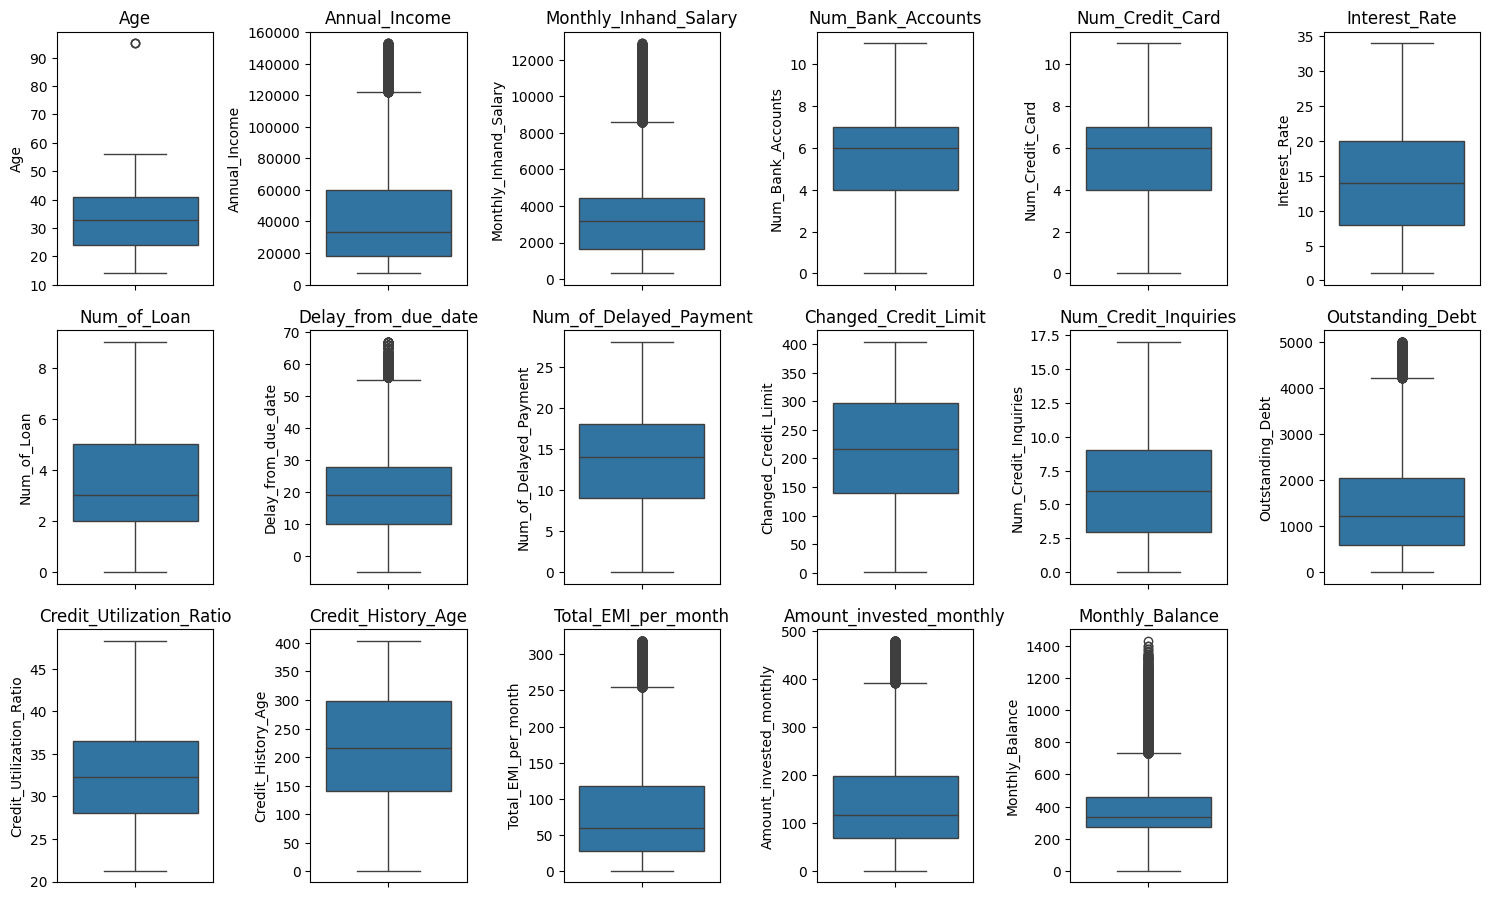

In [36]:
plt.figure(figsize=(15, 15))

for i, column in enumerate(numerical_featues):
    plt.subplot(5, 6, i + 1)  
    sns.boxplot(y=credit_data[column])  
    plt.title(column)

plt.tight_layout()  
plt.show()

Построим гистограммы и посмотрим распределения числовых признаков

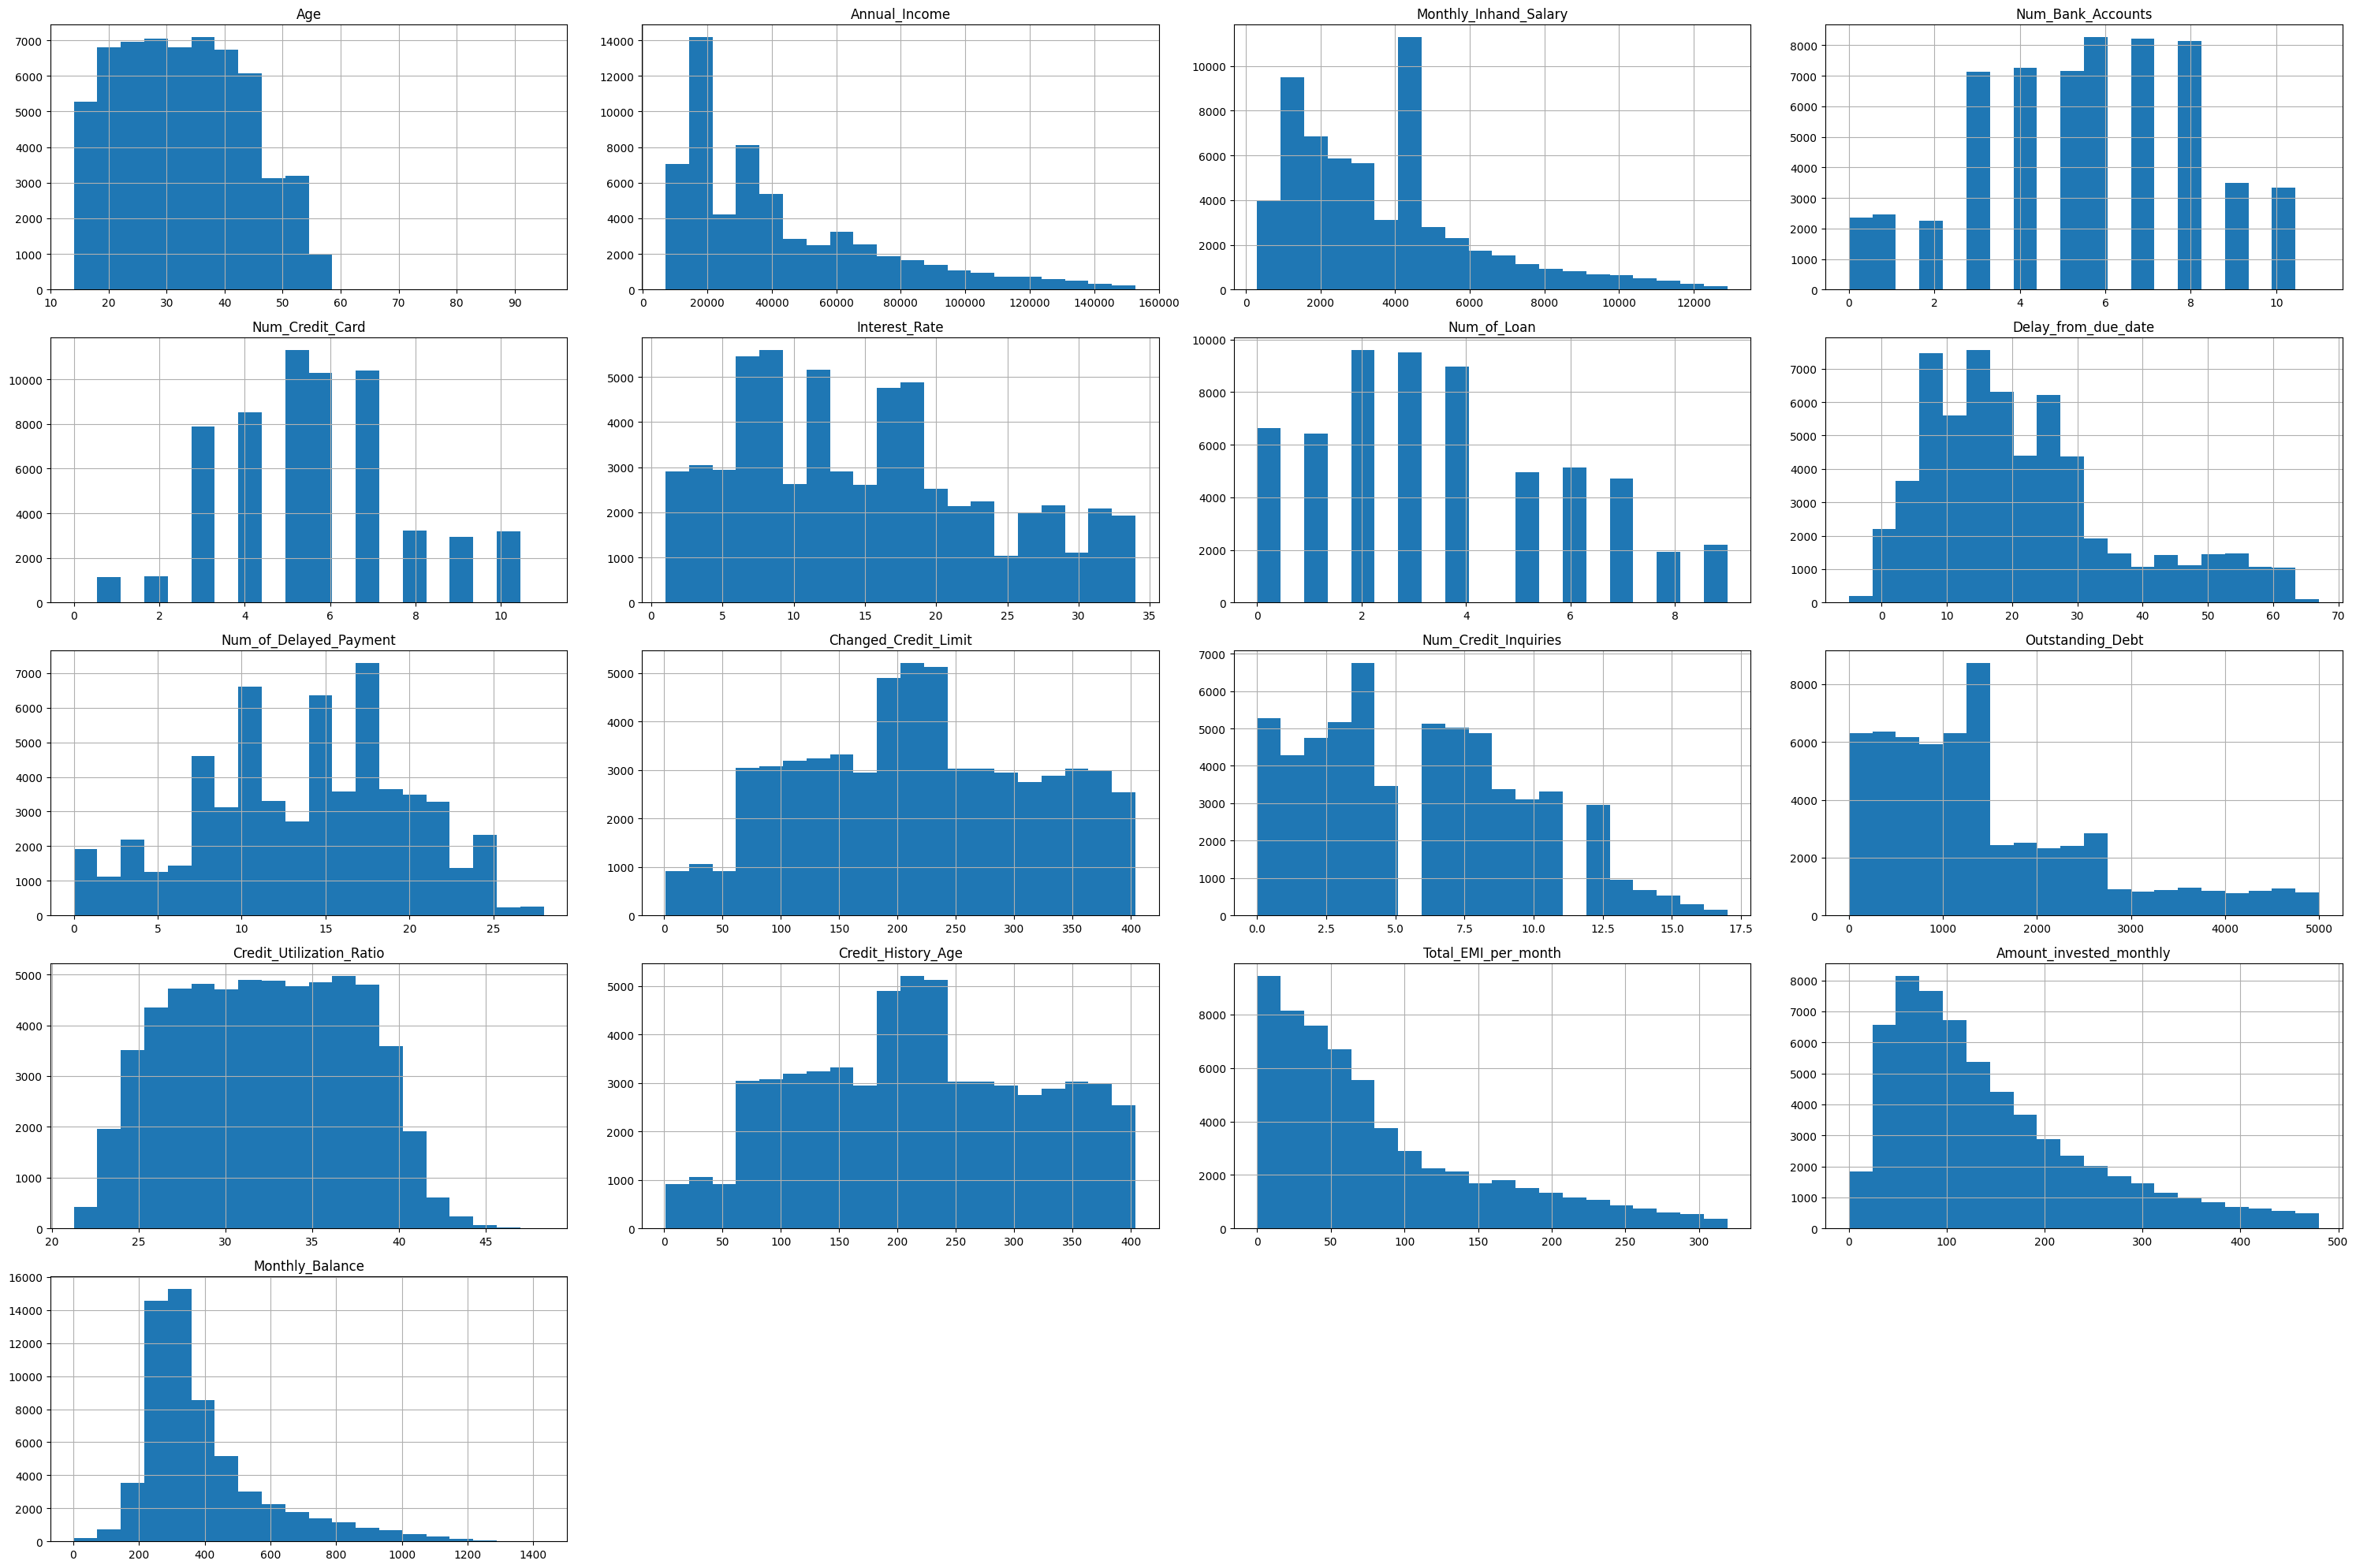

In [37]:
credit_data[numerical_featues].hist(bins=20, figsize=(30, 20))
plt.tight_layout()
plt.show()

Теперь посмотрим как распределены эти признаки относительно предсказуемого класса `Credit_Score`

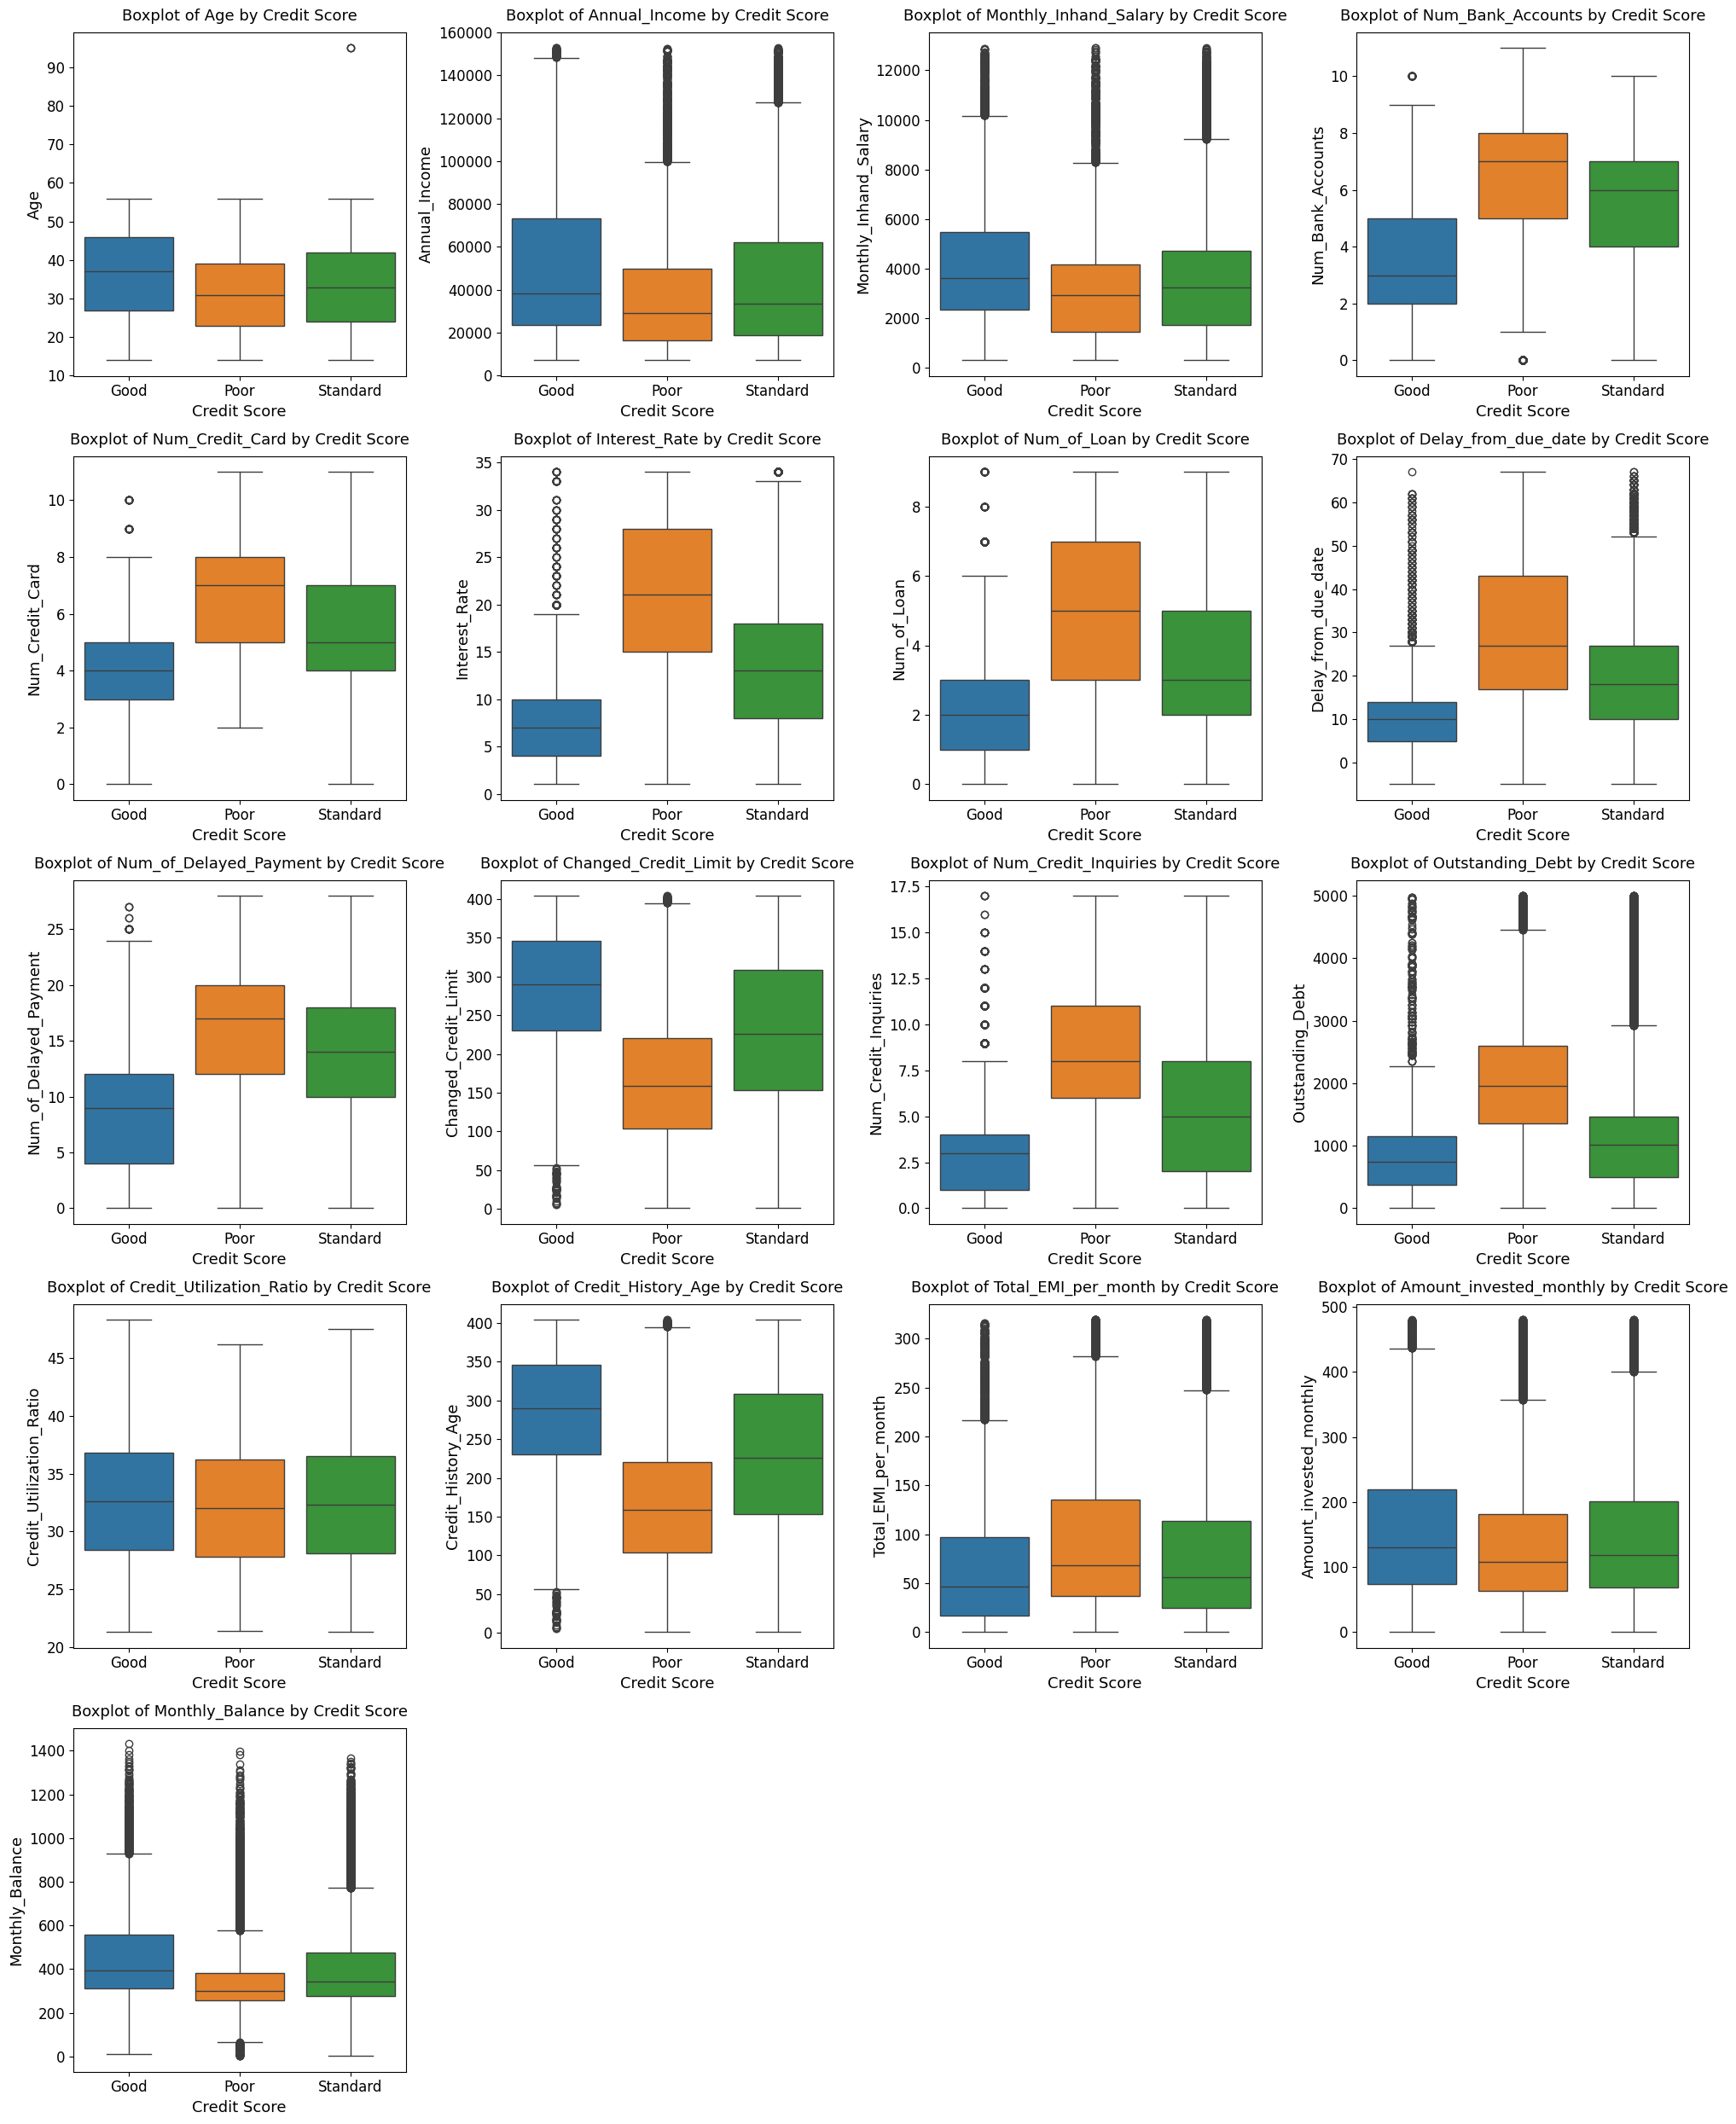

In [38]:
num_cols = 4
num_rows = (len(numerical_featues) + num_cols - 1) // num_cols

plt.figure(figsize=(20, num_rows * 5))

for i, col in enumerate(numerical_featues):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(x='Credit_Score', y=col, data=credit_data, hue='Credit_Score')
    plt.title(f'Boxplot of {col} by Credit Score', fontsize=13, pad=10)
    plt.xlabel('Credit Score', fontsize=13)
    plt.ylabel(col, fontsize=13)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.4, hspace=0.7)
plt.tight_layout()
plt.show()

Построим графики для категориальных признаков

In [39]:
payment_behaviour_mapping = {
    'Low_spent_Small_value_payments': 1,
    'Low_spent_Medium_value_payments': 2,
    'Low_spent_Large_value_payments': 3,
    'High_spent_Small_value_payments': 4,
    'High_spent_Medium_value_payments': 5,
    'High_spent_Large_value_payments': 6}

credit_data['Payment_Behaviour_encoded'] = credit_data['Payment_Behaviour'].map(payment_behaviour_mapping)
credit_data['Payment_Behaviour_encoded'] = pd.to_numeric(credit_data['Payment_Behaviour_encoded'], downcast='integer')

print(credit_data[['Payment_Behaviour', 'Payment_Behaviour_encoded']].head())

                 Payment_Behaviour  Payment_Behaviour_encoded
0  High_spent_Small_value_payments                          4
3   Low_spent_Small_value_payments                          1
5   Low_spent_Small_value_payments                          1
6   Low_spent_Small_value_payments                          1
8   Low_spent_Small_value_payments                          1


In [40]:
occupation_mapping = {
    'Lawyer': 1,
    'Teacher': 2,
    'Mechanic': 3,
    'Engineer': 4,
    'Journalist': 5,
    'Scientist': 6,
    'Architect': 7,
    'Accountant': 8,
    'Developer': 9,
    'Doctor': 10,
    'Media_Manager': 11,
    'Entrepreneur': 12,
    'Writer': 13,
    'Musician': 14,
    'Manager': 15}

credit_data['Occupation_enc'] = credit_data['Occupation'].map(occupation_mapping)
credit_data['Occupation_enc'] = pd.to_numeric(credit_data['Occupation_enc'], downcast='integer')

print(credit_data[['Occupation', 'Occupation_enc']].head(5))

  Occupation  Occupation_enc
0  Scientist               6
3  Scientist               6
5  Scientist               6
6  Scientist               6
8     Lawyer               1


In [41]:
credit_data = credit_data.drop(['Occupation', 'Payment_Behaviour'], axis=1)
credit_data = credit_data.rename(columns={'Occupation_enc' : 'Occupation', 'Payment_Behaviour_encoded' : 'Payment_Behaviour'})

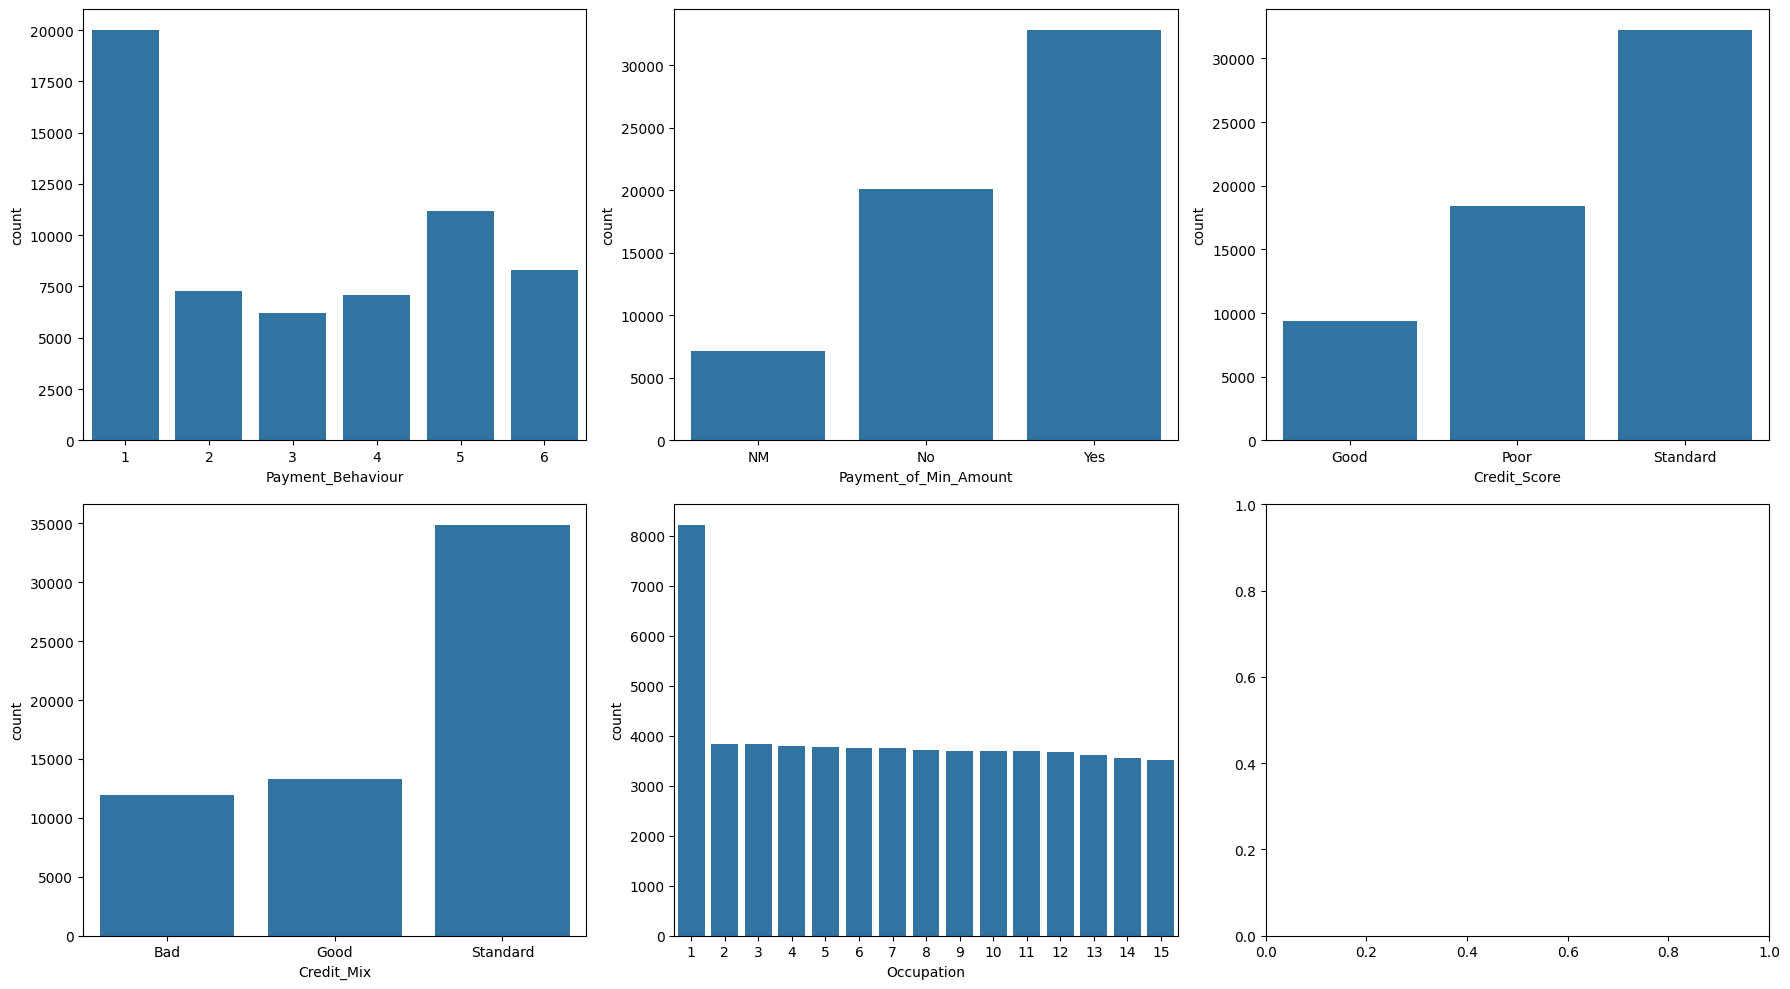

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.countplot(ax=axes[0, 0], data=credit_data, x='Payment_Behaviour')
sns.countplot(ax=axes[0, 1], data=credit_data, x='Payment_of_Min_Amount')
sns.countplot(ax=axes[0, 2], data=credit_data, x='Credit_Score')
sns.countplot(ax=axes[1, 0], data=credit_data, x='Credit_Mix')
sns.countplot(ax=axes[1, 1], data=credit_data, x='Occupation')

fig.tight_layout()

### Обработка категориальных признаков
Используем метод бинаризации (one-hot encoding)

In [43]:
credit_data['Type_of_Loan'] = credit_data['Type_of_Loan'].str.replace('and', ',', regex=False).str.strip()

loan_dummies = credit_data['Type_of_Loan'].str.get_dummies(sep=', ')

credit_data = credit_data.drop(['Type_of_Loan'], axis=1)
credit_data = pd.concat([credit_data, loan_dummies],axis=1)

tmp =  ['Payment_of_Min_Amount',
        'Credit_Mix']

for col in tmp:
    dummies = pd.get_dummies(credit_data[col]).astype('int')
    credit_data=credit_data.drop(columns=col)
    credit_data=pd.concat([credit_data, dummies],axis=1)
credit_data.shape

(60087, 35)

In [44]:
credit_data.columns

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'Credit_Score', 'Payment_Behaviour', 'Occupation',
       'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan',
       'Home Equity Loan', 'Mortgage Loan', 'Not Specified', 'Payday Loan',
       'Personal Loan', 'Student Loan', 'NM', 'No', 'Yes', 'Bad', 'Good',
       'Standard'],
      dtype='object')

### Нормализация числовых признаков

In [45]:
for i in credit_data.columns.to_list():
    if i != 'Credit_Score':
        credit_data[i] = (credit_data[i] - credit_data[i].mean(axis = 0)) / credit_data[i].std(axis = 0)

In [46]:
credit_data.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Payment_Behaviour,Occupation,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan,NM,No,Yes,Bad,Good,Standard
count,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04,6.008700e+04
mean,1.754864e-16,1.348076e-16,-2.525870e-16,-1.220364e-16,1.782063e-16,6.196422e-17,-6.598480e-17,8.041158e-17,-1.248745e-16,4.375336e-17,3.689472e-17,-5.203102e-18,-8.871289e-16,4.375336e-17,-2.388697e-16,-3.263764e-17,-3.578315e-16,-1.371727e-17,-6.527528e-17,-2.175843e-17,-3.784074e-17,-1.008692e-16,-1.915688e-17,-9.081778e-17,3.311065e-18,-8.703371e-17,-6.007218e-17,-5.463257e-17,7.449896e-18,5.888966e-17,-3.760424e-17,2.317746e-17,-2.365046e-18,-4.588190e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.778471e+00,-1.133175e+00,-1.377977e+00,-2.148647e+00,-2.717072e+00,-1.586968e+00,-1.466815e+00,-1.779362e+00,-2.231589e+00,-2.172297e+00,-1.481242e+00,-1.257775e+00,-2.163913e+00,-2.172297e+00,-1.106369e+00,-1.413881e+00,-2.034178e+00,-1.124459e+00,-1.413313e+00,-6.685809e-01,-6.873048e-01,-6.813539e-01,-6.782660e-01,-6.765405e-01,-8.648837e-01,-6.872523e-01,-6.778738e-01,-6.765667e-01,-3.672771e-01,-7.090082e-01,-1.097986e+00,-4.980864e-01,-5.321070e-01,-1.176477e+00
25%,-8.500783e-01,-7.772987e-01,-8.220449e-01,-5.851455e-01,-7.777517e-01,-7.901431e-01,-6.433172e-01,-7.779304e-01,-7.624513e-01,-7.797834e-01,-7.170328e-01,-7.533254e-01,-8.292113e-01,-7.797834e-01,-7.403410e-01,-7.575585e-01,-6.369792e-01,-1.124459e+00,-9.709544e-01,-6.685809e-01,-6.873048e-01,-6.813539e-01,-6.782660e-01,-6.765405e-01,-8.648837e-01,-6.872523e-01,-6.778738e-01,-6.765667e-01,-3.672771e-01,-7.090082e-01,-1.097986e+00,-4.980864e-01,-5.321070e-01,-1.176477e+00
50%,-1.452530e-02,-3.002321e-01,-1.792217e-01,1.966054e-01,1.919084e-01,-1.071504e-01,-2.315681e-01,-1.770713e-01,5.373604e-02,-1.840908e-02,4.717673e-02,-2.200140e-01,2.705722e-03,-1.840908e-02,-3.110577e-01,-2.807333e-01,-3.181861e-01,-6.265305e-02,-8.623802e-02,-6.685809e-01,-6.873048e-01,-6.813539e-01,-6.782660e-01,-6.765405e-01,-8.648837e-01,-6.872523e-01,-6.778738e-01,-6.765667e-01,-3.672771e-01,-7.090082e-01,9.107430e-01,-4.980864e-01,-5.321070e-01,8.499813e-01
75%,7.281885e-01,5.468365e-01,3.253861e-01,5.874808e-01,6.767384e-01,5.758423e-01,5.919299e-01,4.237879e-01,7.066859e-01,8.030737e-01,8.113863e-01,4.931088e-01,8.300531e-01,8.030737e-01,4.887064e-01,5.017439e-01,3.104055e-01,9.991532e-01,7.984784e-01,1.495680e+00,1.454934e+00,1.467642e+00,1.474323e+00,1.478083e+00,1.156206e+00,1.455045e+00,1.475176e+00,1.478026e+00,-3.672771e-01,1.410398e+00,9.107430e-01,-4.980864e-01,-5.321070e-01,8.499813e-01
max,5.741507e+00,3.514714e+00,3.830264e+00,2.150982e+00,2.616058e+00,2.169492e+00,2.238926e+00,3.027511e+00,2.339061e+00,1.864990e+00,2.849278e+00,3.034067e+00,3.162379e+00,1.864990e+00,3.202839e+00,3.242361e+00,5.327392e+00,1.530056e+00,1.683195e+00,1.

### Разбитие данных на тестовую и обучающую выборки  

In [47]:
X = credit_data.drop(['Credit_Score'], axis=1)
y = credit_data['Credit_Score']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(48069, 12018)

### Обучение модели

In [49]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [50]:
y_pred = model.predict(X_test)

Метрики

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

In [52]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.7153
Precision: 0.7160
Recall: 0.7153
F1-score: 0.7156


#### Подбор гиперпараметров

In [53]:
scores_data = pd.DataFrame()

for i in range(1, 25):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    mean_cross_val_score = cross_val_score(model, X_train, y_train, cv=5).mean()
    temp_score_data = pd.DataFrame({'neighbors' : [i], 'train_score' : [train_score], 'test_score' : [test_score], 'cross_val_score' : mean_cross_val_score})
    scores_data =pd.concat([scores_data, temp_score_data])

In [54]:
scores_data_long = pd.melt(scores_data, id_vars=['neighbors'], value_vars=['train_score', 'test_score', 'cross_val_score'], var_name='type', value_name='score')

<Axes: xlabel='neighbors', ylabel='score'>

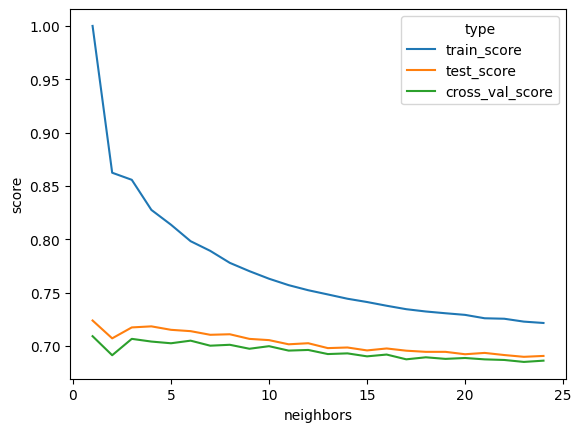

In [55]:
sns.lineplot(x='neighbors', y='score', hue='type', data=scores_data_long)

In [56]:
scores_data_long.query("type == 'cross_val_score'").head(20)

,neighbors,type,score
48,1,cross_val_score,0.709293
49,2,cross_val_score,0.691443
50,3,cross_val_score,0.706796
51,4,cross_val_score,0.704258
52,5,cross_val_score,0.702656
53,6,cross_val_score,0.705111
54,7,cross_val_score,0.700389
55,8,cross_val_score,0.701242
56,9,cross_val_score,0.697518
57,10,cross_val_score,0.699931


In [57]:
model = KNeighborsClassifier(n_neighbors=3)
cross_val_score(model, X_test, y_test, cv=5).mean()

np.float64(0.6446163039406511)

#### Рассмотрим другой классификатор

In [64]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

In [59]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.7977
Precision: 0.7973
Recall: 0.7977
F1-score: 0.7974


### Вывод:
Изучен вопрос об классификации рисков выдачи кредита с учётом нескольких признаков.  
Построена модель классифицирующая заявки.  
RandomForestClassifier справляется с задачей немного лучше чем KNeighborsClassifier.

### Кластеризация
Рассмотрим задачу кластеризации по целевой метке.  
Используем методы KMeans, DBSCAN, OPTICS 

In [62]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [63]:
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
X_train = scaler.fit_transform(X_train)

In [66]:
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)
predicted_train_encoded = label_encoder.fit_transform(y_train_pred)
predicted_test_encoded = label_encoder.fit_transform(y_pred)

In [71]:
def evaluate_clustering(true_labels, predicted_labels, method_name):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    silhouette = silhouette_score(X, predicted_labels) if len(set(predicted_labels)) > 1 else -1
    print(f"{method_name}:\n Adjusted Rand Index: {ari:.4f}\n Silhouette Score: {silhouette:.4f}\n")

In [78]:
def getMaxFitLabels(test_clusters, target):
  arr = [0, 1, 2]
  all_permutations = list(permutations(arr))
  test_clusters_correct = None
  maxAccuracy = 0
  for i in range(len(all_permutations)):
    test_clusters_tmp = test_clusters
    test_clusters_tmp[test_clusters_tmp == 0] = 3
    test_clusters_tmp[test_clusters_tmp == 1] = 4
    test_clusters_tmp[test_clusters_tmp == 2] = 5
    test_clusters_tmp[test_clusters_tmp == 3] = all_permutations[i][0]
    test_clusters_tmp[test_clusters_tmp == 4] = all_permutations[i][1]
    test_clusters_tmp[test_clusters_tmp == 5] = all_permutations[i][2]
    accuracy_tmp =  accuracy_score(target, test_clusters_tmp)
    if (accuracy_tmp > maxAccuracy):
      test_clusters_correct = test_clusters_tmp
      maxAccuracy = accuracy_tmp
  return maxAccuracy, test_clusters_correct

Визуализация кластеров по истинным меткам

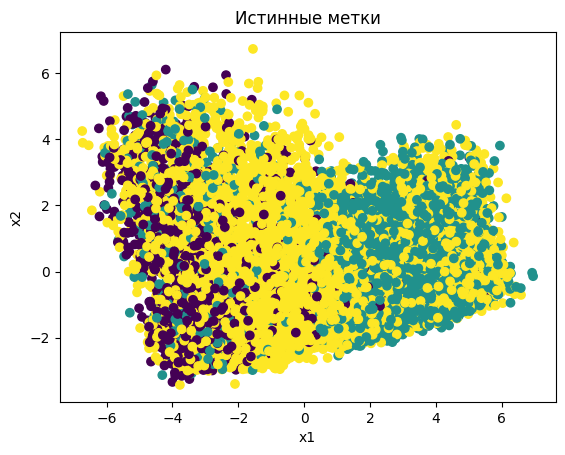

In [ ]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_encoded)
plt.title('Истинные метки')
plt.xlabel('x1')
plt.ylabel('x2')
pass

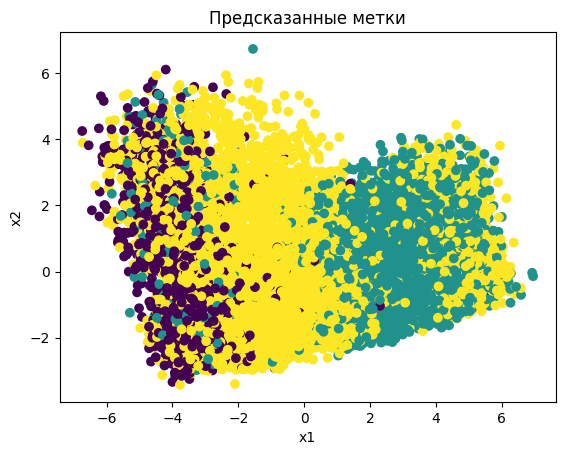

In [102]:
X_test_pca = pca.fit_transform(X_test)

plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=predicted_test_encoded)
plt.title('Предсказанные метки')
plt.xlabel('x1')
plt.ylabel('x2')
pass

Метод KMeans

In [69]:
kmeans = KMeans(n_clusters=3, random_state=99, init='k-means++')
kmeans.fit(X_train)
train_clusters_kmeans = kmeans.predict(X_train)
test_clusters_kmeans = kmeans.predict(X_test)

Сравнение результатов по истинным меткам

In [82]:
kmeansAccuracy, test_clusters_kmeans_correct = getMaxFitLabels(test_clusters_kmeans, y_test_encoded)
kmeans_error = np.mean(test_clusters_kmeans_correct != y_test_encoded)
print("Ошибка: ", kmeans_error)
print("Точность: ", kmeansAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_kmeans_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.6474454984190381
Точность:  0.5890331169911799
Confusion Matrix:
[[ 280   43 1555]
 [ 988 2116  560]
 [3408 1227 1841]]


Сравнение результатов по предсказанным меткам

In [ ]:
kmeansAccuracy, test_clusters_kmeans_correct = getMaxFitLabels(test_clusters_kmeans, predicted_test_encoded)
kmeans_error = np.mean(test_clusters_kmeans_correct != y_test_encoded)
print("Ошибка: ", kmeans_error)
print("Точность: ", kmeansAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_kmeans_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.7610251289732068
Точность:  0.36070893659510733
Confusion Matrix:
[[  43  280 1555]
 [2116  988  560]
 [1227 3408 1841]]


Визуализация кластеров для KMeans

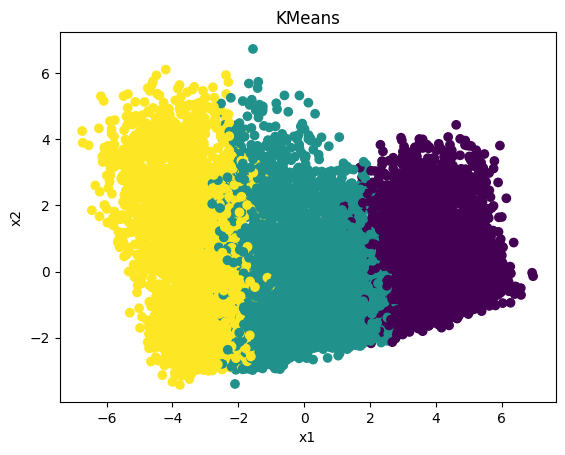

In [85]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_clusters_kmeans)
plt.title('KMeans')
plt.xlabel('x1')
plt.ylabel('x2')
pass

Метод DBSCAN

In [98]:
dbscan = DBSCAN(eps=2.5, min_samples=10)
train_clusters_dbscan = dbscan.fit(X_train).labels_
test_clusters_dbscan = dbscan.fit(X_test).labels_

In [88]:
dbscanAccuracy, test_clusters_dbscan_correct = getMaxFitLabels(test_clusters_dbscan, y_test_encoded)
dbscan_error = np.mean(test_clusters_dbscan_correct != y_test_encoded)
print("Ошибка: ", dbscan_error)
print("Точность: ", dbscanAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_dbscan_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.9997503744383425
Точность:  0.001164919287735064
Confusion Matrix:
[[   0    0    0    0]
 [1865    0   13    0]
 [3661    0    3    0]
 [6462    0   14    0]]


In [89]:
dbscanAccuracy, test_clusters_dbscan_correct = getMaxFitLabels(test_clusters_dbscan, predicted_test_encoded)
dbscan_error = np.mean(test_clusters_dbscan_correct != y_test_encoded)
print("Ошибка: ", dbscan_error)
print("Точность: ", dbscanAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_dbscan_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.9989182892328174
Точность:  0.0016641704110500915
Confusion Matrix:
[[   0    0    0    0]
 [1865   13    0    0]
 [3661    3    0    0]
 [6462   14    0    0]]


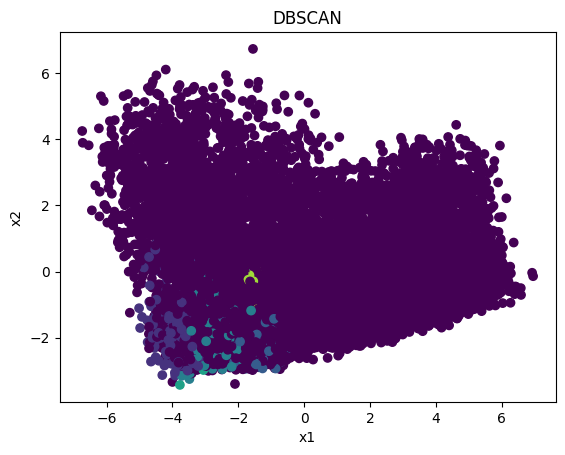

In [99]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_clusters_dbscan)
plt.title('DBSCAN')
plt.xlabel('x1')
plt.ylabel('x2')
pass

Метод OPTICS

In [87]:
optics = OPTICS(max_eps=2.1, min_samples=12)
train_clusters_optics = optics.fit(X_train).labels_
test_clusters_optics = optics.fit(X_test).labels_

In [90]:
opticsAccuracy, test_clusters_optics_correct = getMaxFitLabels(test_clusters_optics, y_test_encoded)
optics_error = np.mean(test_clusters_optics_correct != y_test_encoded)
print("Ошибка: ", optics_error)
print("Точность: ", opticsAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_optics_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.999833582958895
Точность:  0.0010817107671825595
Confusion Matrix:
[[   0    0    0    0]
 [1868    0   10    0]
 [3662    0    2    0]
 [6463    0   13    0]]


In [91]:
opticsAccuracy, test_clusters_optics_correct = getMaxFitLabels(test_clusters_optics, predicted_test_encoded)
optics_error = np.mean(test_clusters_optics_correct != y_test_encoded)
print("Ошибка: ", optics_error)
print("Точность: ", opticsAccuracy)
cm = confusion_matrix(y_test_encoded, test_clusters_optics_correct)
print("Confusion Matrix:")
print(cm)

Ошибка:  0.999167914794475
Точность:  0.0014145448493925778
Confusion Matrix:
[[   0    0    0    0]
 [1868   10    0    0]
 [3662    2    0    0]
 [6463   13    0    0]]


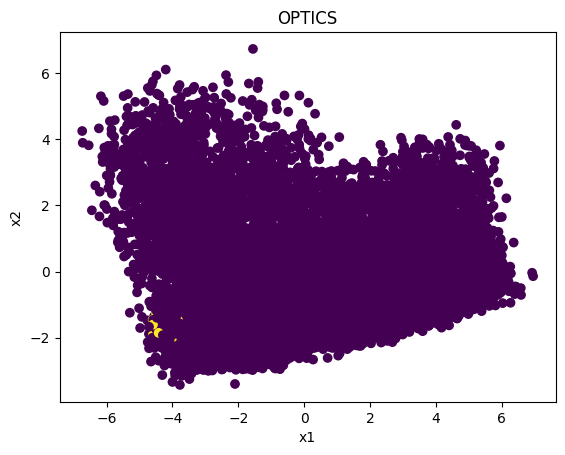

In [93]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_clusters_optics)
plt.title('OPTICS')
plt.xlabel('x1')
plt.ylabel('x2')
pass

### Вывод
Данные оказались сложны для разбиения, о чём говорит плохая точность методов  KMeans, DBSCAN и OPTICS. KMeans справился лучше, чем DBSCAN и OPTICS.

Плохие результаты решения задачи классификации предвещали плохой результат кластеризации.

Некоторые признаки оказывают большое влияние на целевую переменную, можно попробовать исключить менее весомые признаки.   
Также можно исключить коррелирующие признаки.  
Всё это может превести к улучшениям результатов.  